Text(0.5, 1.0, 'Validation')

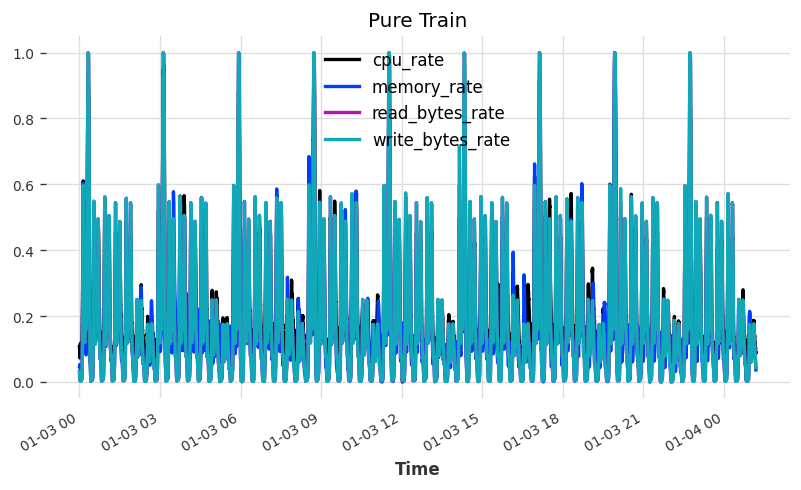

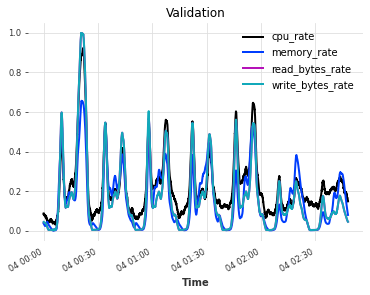

In [1]:
import torch
import numpy as np
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append("../../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune
import os
from matplotlib.pyplot import figure

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

figure(figsize=(8, 4), dpi=120)


dl =  DatasetLoader( '../../pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    resample_freq="1s", augment=False, shift_df_datetime="2022-01-03 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_first = 9*scaled_one_week
train = dl.series_scaled[:idx_first]
val = dl.series_scaled[idx_first:]
# train , val=  dl.get_train_val_by_date(train_end="2022-01-07 00:00:00")
# val = val[:-1]
# tmp_train = train.copy()
# for _ in range(6):
#     train = dl.series_append(train, tmp_train)
    
# train = dl.simple_add_augment(train, -0.01, 0.025, 0.005)

    
train.plot()
plt.title("Pure Train")
val = dl.shift_series_to(val, "2022-04-04 00:00:00")

val.plot(new_plot=True)
plt.title("Validation")



In [2]:
def generate_encoders(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

In [4]:
quantiles = [0.1, 0.5, 0.9]

model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=300,
    output_chunk_length=600,
    hidden_size=25,
    n_rnn_layers=2,
    batch_size=512,
    n_epochs=200,
    dropout=0.1,
    save_checkpoints=True,
#     model_name="sun_GRU",
     add_encoders={
    'cyclic': {'past': ['dayofweek', 'hour', 'minute', 'second']},
#     'custom': {'past': [generate_encoders]},
    'custom': {'past': [generate_encoders]},
#     "position": {"past": ["relative"]},
    'transformer': Scaler()
    },
    likelihood=QuantileRegression(
        quantiles=quantiles
    ), 
    work_dir="logs/lstm_nohparam",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    torch_device_str='cuda:0'
)

In [ ]:
model.fit(train, val_series=val, verbose=True)

[2022-03-25 16:42:21,874] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89821 samples.
[2022-03-25 16:42:21,874] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89821 samples.
[2022-03-25 16:42:21,882] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-25 16:42:21,882] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/200 [00:00<?, ?it/s]

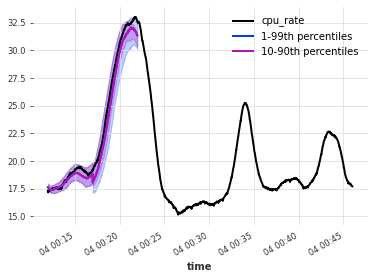

<Figure size 960x480 with 0 Axes>

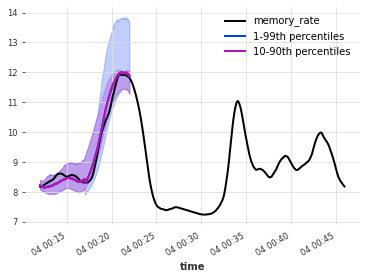

<Figure size 960x480 with 0 Axes>

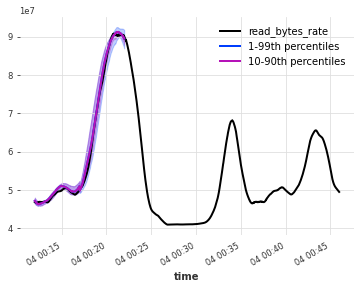

<Figure size 960x480 with 0 Axes>

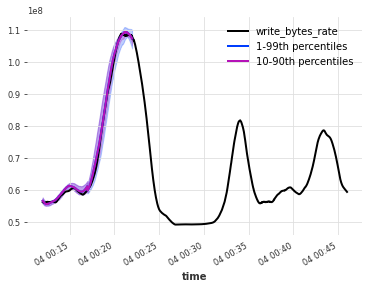

<Figure size 960x480 with 0 Axes>

In [9]:
cut_off = 1440//2
pred_len = 600
pred = model.predict(series=val[:cut_off], n=pred_len, num_samples=500)
pred = dl.scaler.inverse_transform(pred)
val_back = dl.scaler.inverse_transform(val)
for i in range(pred.n_components):
    val_back[cut_off:cut_off+pred_len+1440].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
    plt.savefig(str(i))
    plt.show()

In [61]:
pred = dl.scaler.inverse_transform(pred)

In [19]:
quantiles = [0.1, 0.5, 0.9]

pred = model.predict(series=val[:300], n=1440 ,num_samples=100)
rr = 0.0
for rho in quantiles:
    rr += rho_risk(val[300:], pred, rho=rho)
rr = rr / len(quantiles)
    

In [20]:
rr

0.01920877554173023

In [15]:
pred

<TimeSeries (DataArray) (time: 10, component: 4, sample: 100)>
array([[[0.08996766, 0.08996766, 0.08996766, ..., 0.08996766,
         0.08996766, 0.08996766],
        [0.05029565, 0.05029565, 0.05029565, ..., 0.05029565,
         0.05029565, 0.05029565],
        [0.04698888, 0.04698888, 0.04698888, ..., 0.04698888,
         0.04698888, 0.04698888],
        [0.04731917, 0.04731917, 0.04731917, ..., 0.04731917,
         0.04731917, 0.04731917]],

       [[0.0896505 , 0.0896505 , 0.0896505 , ..., 0.0896505 ,
         0.0896505 , 0.0896505 ],
        [0.04916468, 0.04916468, 0.04916468, ..., 0.04916468,
         0.04916468, 0.04916468],
        [0.0463075 , 0.0463075 , 0.0463075 , ..., 0.0463075 ,
         0.0463075 , 0.0463075 ],
        [0.04665208, 0.04665208, 0.04665208, ..., 0.04665208,
         0.04665208, 0.04665208]],

       [[0.08923896, 0.08923896, 0.08923896, ..., 0.08923896,
         0.08923896, 0.08923896],
...
        [0.04254697, 0.04254697, 0.04254697, ..., 0.04254697,
         0.04254697, 0.04254697]],

       [[0.08643185, 0.08643185, 0.08643185, ..., 0.08643185,
         0.08643185, 0.08643185],
        [0.04680282, 0.04680282, 0.04680282, ..., 0.04680282,
         0.04680282, 0.04680282],
        [0.04187135, 0.04187135, 0.04187135, ..., 0.04187135,
         0.04187135, 0.04187135],
        [0.0422608 , 0.0422608 , 0.0422608 , ..., 0.0422608 ,
         0.0422608 , 0.0422608 ]],

       [[0.08618866, 0.08618866, 0.08618866, ..., 0.08618866,
         0.08618866, 0.08618866],
        [0.04647046, 0.04647046, 0.04647046, ..., 0.04647046,
         0.04647046, 0.04647046],
        [0.04128357, 0.04128357, 0.04128357, ..., 0.04128357,
         0.04128357, 0.04128357],
        [0.04202749, 0.04202749, 0.04202749, ..., 0.04202749,
         0.04202749, 0.04202749]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-01-04T01:12:00 ... 2022-01-04T01:12:09
  * component  (component) object 'cpu_rate' ... 'write_bytes_rate'
Dimensions without coordinates: sample